<a href="https://colab.research.google.com/github/betelgeus/study/blob/master/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Интро
Код ниже это пример реализации сверточной нейронной сети AlexNet для распознавания изображений, реализованной на библиотеке TensorFlow. 

Увы и ах, ни одна приличная библиотека не умеет работать на GPU Radeon  MacBook Pro, ждать пока модель обучиться на CPU нестерпимая боль, поэтому пришлось заморачиваться с Colab и подключением Google Drive. 

In [ ]:
# Импортируем библиотеки
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# провериим, что TF использует GPU, в выводе должен быть девайс с типом GPU
# тут подробнее: https://www.tensorflow.org/guide/gpu 
# https://www.tensorflow.org/api_docs/python/tf/debugging/set_log_device_placement
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# подключим Google Drive для загрузки изображений
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# зададим размер батча и изображений (размер изображений — это output) 
batch_size = 10
img_height = 1104
img_width = 1086

In [ ]:
# Путь где лежат изображения. Для TF рекомендована следующая структура:
# - dir_path:
# -- class_a:
# --- image_1.jpg
# --- image_2.jpg
# --- ...
# -- class_b:
# --- image_1.jpg
# --- image_2.jpg
# --- ...
# -- ...:

# тут подробнее: https://www.tensorflow.org/tutorials/load_data/images

data_dir = pathlib.Path('/content/drive/MyDrive/Photos_for_train')

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87 files belonging to 2 classes.
Using 70 files for training.


In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87 files belonging to 2 classes.
Using 17 files for validation.


In [ ]:
# проверим, что классы определяются корректно
class_names = train_ds.class_names
print(class_names)

['dasha', 'tima']


In [ ]:
# визуализация изображений
# .take(1) отвечает за количество батчей, которое мы возьмем
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) # uint8 8-ми битный тип данных [0, 255], после рескейлинга .astype("uint8")нужно убрать
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Изображений в исходном датасете кот наплакалал, что вполне логично приводит к адскому переобучению. Попробуем победить переобучение 
# с помощью аугментации — метод увеличения датасета слегка искаженными исходными изображениями. Тем более, в TF есть готовые методы 
# для создания аугментированных картинок. 

# тут подробнее + примеры других способов реализации: https://www.tensorflow.org/tutorials/images/data_augmentation
# полный пайплайн: https://www.tensorflow.org/tutorials/images/classification 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# чтобы не ждать вечность пока модель обучиться выполним скейлинг из [0,255] в [0, 1] 
rescale = keras.Sequential([
  layers.Rescaling(1./255)
])

In [ ]:
# исходный данных совсем мало, поэтому с помощью аугментации увеличим размер в 9 раз
train_ds_aug = train_ds
for _ in range(9):  
  aug_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
  # не забудем добавить аугментированные изображения в обучающую выборку
  train_ds_aug = train_ds_aug.concatenate(aug_ds)

# !!! в процессе различных преобразований, крайне внимательно следим за размерами тензоров 
train_ds_aug

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 1104, 1086, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# создадим модель
model=keras.models.Sequential([
    rescale, # слой отвечающий за рескейлинг
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width,3)), # исходные размеры изображений
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax') # количество классов
])

In [ ]:
input_shape = (None, 1104, 1086, 3)

In [ ]:
# соберем модель
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.build(input_shape) # нужна только для слоев, которые отвечают за рескейлинг или аугментацию
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 1104, 1086, 3)     0         
                                                                 
 conv2d_60 (Conv2D)          (None, 274, 269, 128)     46592     
                                                                 
 batch_normalization_60 (Bat  (None, 274, 269, 128)    512       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 137, 134, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 137, 134, 256)     819456    
                                                                 
 batch_normalization_61 (Bat  (None, 137, 134, 256)  

In [ ]:
# обучим модель
epochs = 10

history=model.fit(
    train_ds_aug,
    epochs=epochs,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/10
70/70 [==============================] - 199s 3s/step - loss: 0.7961 - accuracy: 0.7971 - val_loss: 0.6723 - val_accuracy: 0.6471
Epoch 2/10
70/70 [==============================] - 190s 3s/step - loss: 0.3513 - accuracy: 0.8957 - val_loss: 1.1800 - val_accuracy: 0.6471
Epoch 3/10
70/70 [==============================] - 189s 3s/step - loss: 0.3438 - accuracy: 0.9043 - val_loss: 1.5173 - val_accuracy: 0.6471
Epoch 4/10
70/70 [==============================] - 190s 3s/step - loss: 0.0842 - accuracy: 0.9643 - val_loss: 1.1049 - val_accuracy: 0.7647
Epoch 5/10
70/70 [==============================] - 185s 3s/step - loss: 0.0795 - accuracy: 0.9686 - val_loss: 1.0285 - val_accuracy: 0.7647
Epoch 6/10
70/70 [==============================] - 187s 3s/step - loss: 0.0602 - accuracy: 0.9743 - val_loss: 0.3988 - val_accuracy: 0.8235
Epoch 7/10
70/70 [==============================] - 185s 3s/step - loss: 0.1029 - accuracy: 0.9700 - val_loss: 0.0876 - val_accuracy: 0.9412
Epoch 8/10
70

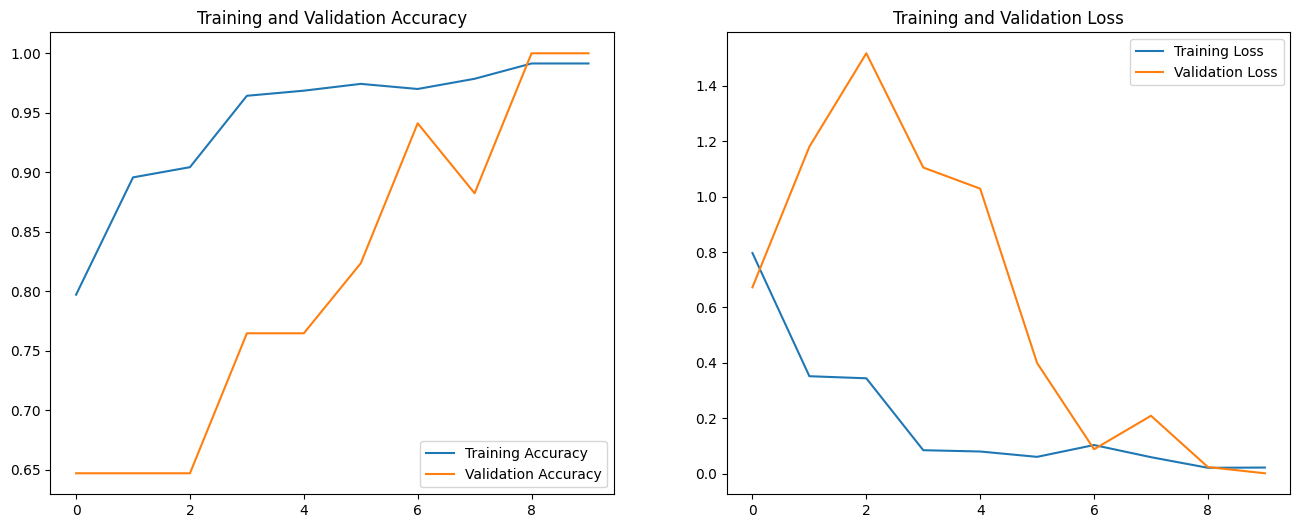

In [ ]:
# построим графики обучения
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# весьма недурный результат, особенно если учесть, что на данных без аугментации модель совсем не хотела учится и оверфитилась уже на 3 эпохе. 

In [ ]:
# добавим тестовые изображения
dir_path1 = '/content/drive/MyDrive/Photo_for_test/dasha/20220215_181913.jpg'
dir_path2 = '/content/drive/MyDrive/Photo_for_test/dasha/20220314_163526.jpg'
dir_path3 = '/content/drive/MyDrive/Photo_for_test/dasha/20220506_190045.jpg'
dir_path4 = '/content/drive/MyDrive/Photo_for_test/tima/IMG_4105.JPG'
dir_path5 = '/content/drive/MyDrive/Photo_for_test/tima/IMG_4185.JPG'
dir_path6 = '/content/drive/MyDrive/Photo_for_test/tima/IMG_4235.JPG'
paths = (dir_path1, dir_path2, dir_path3, dir_path4, dir_path5, dir_path6)

1/1 [==============================] - 0s 26ms/step


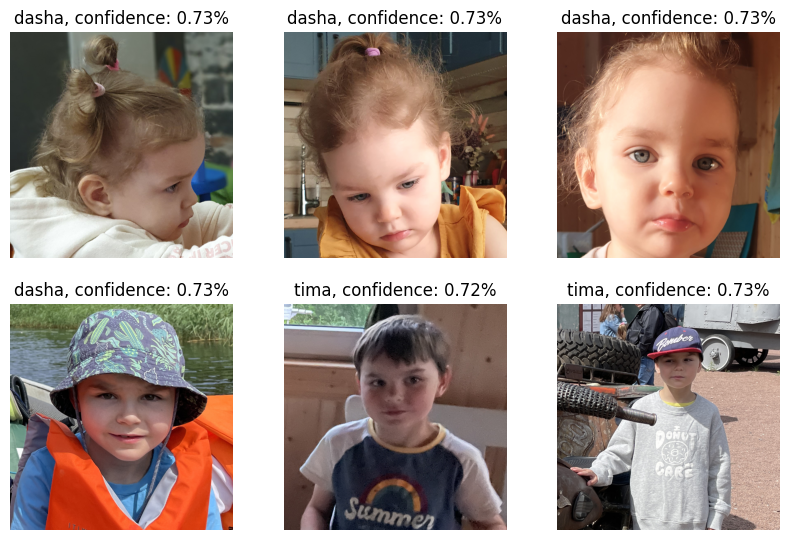

In [ ]:
# проверим обобщающую способность модели на новых изображениях
plt.figure(figsize=(10, 10))
for path, i in zip(paths,range(6)):
    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title('{}, confidence: {:.2f}%'.format(class_names[np.argmax(score)], np.max(score)))
    plt.axis("off")

In [167]:
# вывод: аугментация отлично помогла справиться с оверфитингом и получить вменяемый результат